In [48]:
import cPickle
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit

import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import operator
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from pandas_datareader import data, wb
import pandas_datareader as pdr
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import re
from dateutil import parser
from bt import Strategy#, Portfolio
import quandl

In [49]:
def getStock(symbol, start, end):
    """
    Downloads Stock from Yahoo Finance.
    Computes daily Returns based on Adj Close.
    Returns pandas dataframe.
    """
    
    df =  pdr.data.get_data_yahoo(symbol, start, end)

    df.columns.values[-1] = 'AdjClose'
    df.columns = df.columns + '_' + symbol
    df['Return_%s' %symbol] = df['AdjClose_%s' %symbol].pct_change()
    
    print(df)
    
    return df

d1 = datetime.datetime(2016,5,1)
d2 = datetime.datetime(2017,5,1)

df = getStock("GOOG", d1, d2)

df.columns

             Open_GOOG   High_GOOG    Low_GOOG  Close_GOOG  Volume_GOOG  \
Date                                                                      
2016-05-02  697.630005  700.640015  691.000000  698.210022      1645300   
2016-05-03  696.869995  697.840027  692.000000  692.359985      1543800   
2016-05-04  690.489990  699.750000  689.010010  695.700012      1693500   
2016-05-05  697.700012  702.320007  695.719971  701.429993      1683500   
2016-05-06  698.380005  711.859985  698.106995  711.119995      1826100   
2016-05-09  712.000000  718.710022  710.000000  712.900024      1510300   
2016-05-10  716.750000  723.500000  715.719971  723.179993      1569600   
2016-05-11  723.409973  724.479980  712.799988  715.289978      1692100   
2016-05-12  717.059998  719.250000  709.000000  713.309998      1360700   
2016-05-13  711.929993  716.661987  709.260010  710.830017      1314500   
2016-05-16  709.130005  718.479980  705.650024  716.489990      1317100   
2016-05-17  715.989990  7

Index([u'Open_GOOG', u'High_GOOG', u'Low_GOOG', u'Close_GOOG', u'Volume_GOOG',
       u'AdjClose_GOOG', u'Return_GOOG'],
      dtype='object')

In [50]:
def getStockDataFromWeb(fout, start_string, end_string):
    """
    Collects predictors data from Yahoo Finance and Quandl.
    Returns a list of dataframes.
    """
    start = start_string
    end = end_string
    
    sp500 = getStock('^GSPC', start, end)
    nasdaq = getStock('^IXIC', start, end)
    frankfurt = getStock('^GDAXI', start, end)
    london = getStock('^FTSE', start, end)
    paris = getStock('^FCHI', start, end)
    hkong = getStock('^HSI', start, end)
    nikkei = getStock('^N225', start, end)
    australia = getStock('^AXJO', start, end)
    djia = getStock('^DJI', start, end)
    
    out =  pdr.data.get_data_yahoo(fout, start, end)
    out.columns.values[-1] = 'AdjClose'
    out.columns = out.columns + '_Out'
    out['Return_Out'] = out['AdjClose_Out'].pct_change()
    
    return [out, sp500, nasdaq, djia, frankfurt, london, paris, hkong, nikkei, australia]

d1 = datetime.datetime(2016,4,15)
d2 = datetime.datetime(2017,5,1)

bigDF = getStockDataFromWeb('GOOG',d1, d2)

             Open_^GSPC   High_^GSPC    Low_^GSPC  Close_^GSPC  Volume_^GSPC  \
Date                                                                           
2016-04-15  2083.100098  2083.219971  2076.310059  2080.729980    3701450000   
2016-04-18  2078.830078  2094.659912  2073.649902  2094.340088    3316880000   
2016-04-19  2096.050049  2104.050049  2091.679932  2100.800049    3896830000   
2016-04-20  2101.520020  2111.050049  2096.320068  2102.399902    4184880000   
2016-04-21  2102.090088  2103.780029  2088.520020  2091.479980    4175290000   
2016-04-22  2091.489990  2094.320068  2081.199951  2091.580078    3790580000   
2016-04-25  2089.370117  2089.370117  2077.520020  2087.790039    3319740000   
2016-04-26  2089.840088  2096.870117  2085.800049  2091.699951    3557190000   
2016-04-27  2092.330078  2099.889893  2082.310059  2095.149902    4100110000   
2016-04-28  2090.929932  2099.300049  2071.620117  2075.810059    4309840000   
2016-04-29  2071.820068  2073.850098  20

In [51]:
def addFeatures(dataframe, adjclose, returns, n):
    """
    operates on two columns of dataframe:
    - n >= 2
    - given Return_* computes the return of day i respect to day i-n. 
    - given AdjClose_* computes its moving average on n days

    """
    
    return_n = adjclose[9:] + "Time" + str(n)
    dataframe[return_n] = dataframe[adjclose].pct_change(n)
    
    roll_n = returns[7:] + "RolMean" + str(n)
    dataframe[roll_n] = pd.DataFrame(dataframe[returns]).rolling(window = n).mean()



In [52]:
def applyRollMeanDelayedReturns(datasets, delta):
    """
    applies rolling mean and delayed returns to each dataframe in the list
    """
    for dataset in datasets:
        columns = dataset.columns    
        adjclose = columns[-2]
        returns = columns[-1]
        for n in delta:
            addFeatures(dataset, adjclose, returns, n)
    
    return datasets    

delta = {2}

h = applyRollMeanDelayedReturns(bigDF, delta)

In [53]:
h[0]

,Open_Out,High_Out,Low_Out,Close_Out,Volume_Out,AdjClose_Out,Return_Out,OutTime2,OutRolMean2
Date,,,,,,,,,
2016-04-15,753.979980,761.000000,752.693970,759.000000,1809300,759.000000,NaN,NaN,NaN
2016-04-18,760.460022,768.049988,757.299988,766.609985,1556000,766.609985,0.010026,NaN,NaN
2016-04-19,769.510010,769.900024,749.330017,753.929993,2030500,753.929993,-0.016540,-0.006680,-0.003257
2016-04-20,758.000000,758.132019,750.010010,752.669983,1529200,752.669983,-0.001671,-0.018184,-0.009106
2016-04-21,755.380005,760.450012,749.549988,759.140015,3060500,759.140015,0.008596,0.006910,0.003462
2016-04-22,726.299988,736.119995,713.609985,718.770020,5951900,718.770020,-0.053179,-0.045040,-0.022291
2016-04-25,716.099976,723.929993,715.590027,723.150024,1959200,723.150024,0.006094,-0.047409,-0.023542
2016-04-26,725.419983,725.765991,703.026001,708.140015,2744600,708.140015,-0.020756,-0.014789,-0.007331
2016-04-27,707.289978,708.979980,692.364990,705.840027,3098600,705.840027,-0.003248,-0.023937,-0.012002


In [54]:
def mergeDataframes(datasets, index):
    """
    merges datasets in the list 
    """
    subset = []#tion
    subset = [dataset.iloc[:, index:] for dataset in datasets[1:]]
    
    first = subset[0].join(subset[1:], how = 'outer')
    finance = datasets[0].iloc[:, index:].join(first, how = 'left') 
#    finance = finance[finance.index > cut]
    return finance

index = 6
"""
The cut is not useful
"""
#cut = datetime.datetime(2005,11,4)

mergedDF = mergeDataframes(bigDF, index)

mergedDF

,Return_Out,OutTime2,OutRolMean2,Return_^GSPC,^GSPCTime2,^GSPCRolMean2,Return_^IXIC,^IXICTime2,^IXICRolMean2,Return_^DJI,...,^FCHIRolMean2,Return_^HSI,^HSITime2,^HSIRolMean2,Return_^N225,^N225Time2,^N225RolMean2,Return_^AXJO,^AXJOTime2,^AXJORolMean2
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-18,0.010026,NaN,NaN,0.006541,NaN,NaN,0.004415,NaN,NaN,0.005962,...,NaN,-0.007270,NaN,NaN,-0.033955,NaN,NaN,-0.003955,NaN,NaN
2016-04-19,-0.016540,-0.006680,-0.003257,0.003084,0.009646,0.004813,-0.003970,0.000427,0.000222,0.002746,...,0.007915,0.012982,0.005617,0.002856,0.036771,0.001568,0.001408,0.010064,0.006069,0.003054
2016-04-20,-0.001671,-0.018184,-0.009106,0.000762,0.003848,0.001923,0.001579,-0.002397,-0.001195,0.002364,...,0.009402,-0.009325,0.003535,0.001828,0.001902,0.038744,0.019337,0.005242,0.015359,0.007653
2016-04-21,0.008596,0.006910,0.003462,-0.005194,-0.004436,-0.002216,-0.000453,0.001125,0.000563,-0.006286,...,0.001796,0.018174,0.008679,0.004424,0.027036,0.028989,0.014469,0.010870,0.016170,0.008056
2016-04-22,-0.053179,-0.045040,-0.022291,0.000048,-0.005146,-0.002573,-0.008019,-0.008468,-0.004236,0.001181,...,-0.002427,-0.007178,0.010865,0.005498,0.012029,0.039390,0.019532,-0.006885,0.003911,0.001993
2016-04-25,0.006094,-0.047409,-0.023542,-0.001812,-0.001764,-0.000882,-0.002128,-0.010130,-0.005073,-0.001472,...,-0.004013,-0.007574,-0.014698,-0.007376,-0.007579,0.004359,0.002225,NaN,NaN,NaN
2016-04-26,-0.020756,-0.014789,-0.007331,0.001873,0.000057,0.000030,-0.001534,-0.003659,-0.001831,0.000728,...,-0.003999,0.004827,-0.002784,-0.001374,-0.004933,-0.012475,-0.006256,-0.003017,-0.009881,-0.004951
2016-04-27,-0.003248,-0.023937,-0.012002,0.001649,0.003525,0.001761,-0.005143,-0.006669,-0.003338,0.002848,...,0.001469,-0.002133,0.002683,0.001347,-0.003618,-0.008533,-0.004275,-0.006302,-0.009300,-0.004660


In [55]:
def applyTimeLag(dataset, lags, delta):
    """
    apply time lag to return columns selected according  to delta.
    Days to lag are contained in the lags list passed as argument.
    Returns a NaN free dataset obtained cutting the lagged dataset
    at head and tail
    """
    
    dataset.Return_Out = dataset.Return_Out.shift(-1)
    
    maxLag = max(lags)
 
    allColumns = dataset.columns[:]
  
    for column in allColumns:
        data_col = pd.Series(dataset[column])
        data_col = data_col.interpolate(method='linear', axis=0, limit=None, inplace=False, limit_direction='forward', downcast=None)
        dataset[column] = data_col

    return dataset.iloc[maxLag:-1,:]

lags = {0, 1, 2}

hhh = applyTimeLag(mergedDF, lags, delta)

hhh

,Return_Out,OutTime2,OutRolMean2,Return_^GSPC,^GSPCTime2,^GSPCRolMean2,Return_^IXIC,^IXICTime2,^IXICRolMean2,Return_^DJI,...,^FCHIRolMean2,Return_^HSI,^HSITime2,^HSIRolMean2,Return_^N225,^N225Time2,^N225RolMean2,Return_^AXJO,^AXJOTime2,^AXJORolMean2
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-19,-0.001671,-0.006680,-0.003257,0.003084,0.009646,0.004813,-0.003970,0.000427,0.000222,0.002746,...,0.007915,0.012982,0.005617,0.002856,0.036771,0.001568,0.001408,0.010064,0.006069,0.003054
2016-04-20,0.008596,-0.018184,-0.009106,0.000762,0.003848,0.001923,0.001579,-0.002397,-0.001195,0.002364,...,0.009402,-0.009325,0.003535,0.001828,0.001902,0.038744,0.019337,0.005242,0.015359,0.007653
2016-04-21,-0.053179,0.006910,0.003462,-0.005194,-0.004436,-0.002216,-0.000453,0.001125,0.000563,-0.006286,...,0.001796,0.018174,0.008679,0.004424,0.027036,0.028989,0.014469,0.010870,0.016170,0.008056
2016-04-22,0.006094,-0.045040,-0.022291,0.000048,-0.005146,-0.002573,-0.008019,-0.008468,-0.004236,0.001181,...,-0.002427,-0.007178,0.010865,0.005498,0.012029,0.039390,0.019532,-0.006885,0.003911,0.001993
2016-04-25,-0.020756,-0.047409,-0.023542,-0.001812,-0.001764,-0.000882,-0.002128,-0.010130,-0.005073,-0.001472,...,-0.004013,-0.007574,-0.014698,-0.007376,-0.007579,0.004359,0.002225,-0.004951,-0.002985,-0.001479
2016-04-26,-0.003248,-0.014789,-0.007331,0.001873,0.000057,0.000030,-0.001534,-0.003659,-0.001831,0.000728,...,-0.003999,0.004827,-0.002784,-0.001374,-0.004933,-0.012475,-0.006256,-0.003017,-0.009881,-0.004951
2016-04-27,-0.020996,-0.023937,-0.012002,0.001649,0.003525,0.001761,-0.005143,-0.006669,-0.003338,0.002848,...,0.001469,-0.002133,0.002683,0.001347,-0.003618,-0.008533,-0.004275,-0.006302,-0.009300,-0.004660
2016-04-28,0.002880,-0.024176,-0.012122,-0.009231,-0.007597,-0.003791,-0.011896,-0.016977,-0.008519,-0.011684,...,0.002668,0.001237,-0.000899,-0.000448,-0.036115,-0.039602,-0.019866,0.007267,0.000919,0.000483
2016-04-29,0.007504,-0.018177,-0.009058,-0.005063,-0.014247,-0.007147,-0.006229,-0.018050,-0.009062,-0.003203,...,-0.014311,-0.015007,-0.013789,-0.006885,-0.033618,-0.052857,-0.026742,0.005129,0.012433,0.006198


In [56]:
def prepareDataForCrossValidation(dataset):
    """
    generate categorical output column, set features and return whole data set
    """
    le = preprocessing.LabelEncoder()
    
    dataset['UpDown'] = dataset['Return_Out']
    dataset.UpDown[dataset.UpDown >= 0] = 'Up'
    dataset.UpDown[dataset.UpDown < 0] = 'Down'
    dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown)
    """
    Here set feature from column 3 to the end, get rid of all the colomn related to S&P500
    """
    features = dataset.columns[3:-1]
    X = dataset[features]    
    y = dataset.UpDown
    return [X,y]

[X_whole, y_whole] = prepareDataForCrossValidation(hhh)
X_whole

C:\Users\ljia\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\ljia\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ljia\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Return_^GSPC,^GSPCTime2,^GSPCRolMean2,Return_^IXIC,^IXICTime2,^IXICRolMean2,Return_^DJI,^DJITime2,^DJIRolMean2,Return_^GDAXI,...,^FCHIRolMean2,Return_^HSI,^HSITime2,^HSIRolMean2,Return_^N225,^N225Time2,^N225RolMean2,Return_^AXJO,^AXJOTime2,^AXJORolMean2
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-19,0.003084,0.009646,0.004813,-0.003970,0.000427,0.000222,0.002746,0.008724,0.004354,0.022655,...,0.007915,0.012982,0.005617,0.002856,0.036771,0.001568,0.001408,0.010064,0.006069,0.003054
2016-04-20,0.000762,0.003848,0.001923,0.001579,-0.002397,-0.001195,0.002364,0.005116,0.002555,0.006928,...,0.009402,-0.009325,0.003535,0.001828,0.001902,0.038744,0.019337,0.005242,0.015359,0.007653
2016-04-21,-0.005194,-0.004436,-0.002216,-0.000453,0.001125,0.000563,-0.006286,-0.003937,-0.001961,0.001386,...,0.001796,0.018174,0.008679,0.004424,0.027036,0.028989,0.014469,0.010870,0.016170,0.008056
2016-04-22,0.000048,-0.005146,-0.002573,-0.008019,-0.008468,-0.004236,0.001181,-0.005113,-0.002553,-0.005964,...,-0.002427,-0.007178,0.010865,0.005498,0.012029,0.039390,0.019532,-0.006885,0.003911,0.001993
2016-04-25,-0.001812,-0.001764,-0.000882,-0.002128,-0.010130,-0.005073,-0.001472,-0.000294,-0.000146,-0.007629,...,-0.004013,-0.007574,-0.014698,-0.007376,-0.007579,0.004359,0.002225,-0.004951,-0.002985,-0.001479
2016-04-26,0.001873,0.000057,0.000030,-0.001534,-0.003659,-0.001831,0.000728,-0.000746,-0.000372,-0.003377,...,-0.003999,0.004827,-0.002784,-0.001374,-0.004933,-0.012475,-0.006256,-0.003017,-0.009881,-0.004951
2016-04-27,0.001649,0.003525,0.001761,-0.005143,-0.006669,-0.003338,0.002848,0.003577,0.001788,0.003922,...,0.001469,-0.002133,0.002683,0.001347,-0.003618,-0.008533,-0.004275,-0.006302,-0.009300,-0.004660
2016-04-28,-0.009231,-0.007597,-0.003791,-0.011896,-0.016977,-0.008519,-0.011684,-0.008869,-0.004418,0.002070,...,0.002668,0.001237,-0.000899,-0.000448,-0.036115,-0.039602,-0.019866,0.007267,0.000919,0.000483
2016-04-29,-0.005063,-0.014247,-0.007147,-0.006229,-0.018050,-0.009062,-0.003203,-0.014850,-0.007444,-0.027340,...,-0.014311,-0.015007,-0.013789,-0.006885,-0.033618,-0.052857,-0.026742,0.005129,0.012433,0.006198


In [57]:
def performClassification(X_train, y_train, X_test, y_test, method):
    """
    performs classification on daily returns using several algorithms (method).
    method --> string algorithm
    parameters --> list of parameters passed to the classifier (if any)
    fout --> string with name of stock to be predicted
    savemodel --> boolean. If TRUE saves the model to pickle file
    """
   
    if method == 'RF':   
        return performRFClass(X_train, y_train, X_test, y_test)
        
    elif method == 'KNN':
        return performKNNClass(X_train, y_train, X_test, y_test)
    
    elif method == 'SVM':   
        return performSVMClass(X_train, y_train, X_test, y_test)
    
    elif method == 'ADA':
        return performAdaBoostClass(X_train, y_train, X_test, y_test)
    
    elif method == 'GTB': 
        return performGTBClass(X_train, y_train, X_test, y_test)

    elif method == 'QDA': 
        return performQDAClass(X_train, y_train, X_test, y_test)

In [58]:
def performRFClass(X_train, y_train, X_test, y_test):
    """
    Random Forest Binary Classification
    """
    print 'RF classifier: '
    
    clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    clf.fit(X_train, y_train)

    feature_importance = clf.feature_importances_
    print feature_importance
    accuracy = clf.score(X_test, y_test)
    
        
    y_predict = clf.predict(X_test)
    
    print("y_predict = ", y_predict)
        
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print(tn, fp, fn, tp)
    
    target_names = ['Down', 'Up']
    print(classification_report(y_test, y_predict, target_names=target_names))
    
    return accuracy

#performRFClass (X_train, y_train, X_test, y_test)

In [59]:
def performKNNClass(X_train, y_train, X_test, y_test):
    """
    KNN binary Classification
    """
    
    print 'KNN classifier: ' 
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)
    
    accuracy = clf.score(X_test, y_test)
            
    y_predict = clf.predict(X_test)    
    print 'y_predict = ', y_predict
        
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print '(tn, fp, fn, tp) : (', tn, fp, fn,tp , ')'
    
    target_names = ['Down', 'Up']
    print(classification_report(y_test, y_predict, target_names=target_names))
    
    
    return accuracy
#performKNNClass (X_train, y_train, X_test, y_test)

In [60]:
def performSVMClass(X_train, y_train, X_test, y_test):
    """
    SVM binary Classification
    """
    print 'SVM classifier: ' 
    clf = SVC()
    clf.fit(X_train, y_train)

    accuracy = clf.score(X_test, y_test)
    
    y_predict = clf.predict(X_test)
    print 'y_predict = ', y_predict
        
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print '(tn, fp, fn, tp) : (', tn, fp, fn,tp , ')'
    
    target_names = ['Down', 'Up']
    print(classification_report(y_test, y_predict, target_names=target_names))
    
    return accuracy
#performSVMClass (X_train, y_train, X_test, y_test)

In [61]:
def performAdaBoostClass(X_train, y_train, X_test, y_test):
    """
    Ada Boosting binary Classification
    """
    print 'AdaBoost classifier: ' 
    clf = AdaBoostClassifier()
    clf.fit(X_train, y_train)
    
    accuracy = clf.score(X_test, y_test)

    y_predict = clf.predict(X_test)
    print 'y_predict = ', y_predict
        
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print '(tn, fp, fn, tp) : (', tn, fp, fn,tp , ')'
    
    target_names = ['Down', 'Up']
    print(classification_report(y_test, y_predict, target_names=target_names))
    
    return accuracy
#performAdaBoostClass (X_train, y_train, X_test, y_test)

In [72]:
def performGTBClass(X_train, y_train, X_test, y_test):
    """
    Gradient Tree Boosting binary Classification
    """
    print 'GTB classifier: ' 
    clf = GradientBoostingClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    y_predict = clf.predict(X_test)
    print 'y_predict = ', y_predict
        
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print'(tn, fp, fn, tp) : (', tn, fp, fn,tp , ')'
    
    target_names = ['Down', 'Up']
    print(classification_report(y_test, y_predict, target_names=target_names))
    
    accuracy = clf.score(X_test, y_test)
    
    return accuracy
#performGTBClass(X_train, y_train, X_test, y_test)

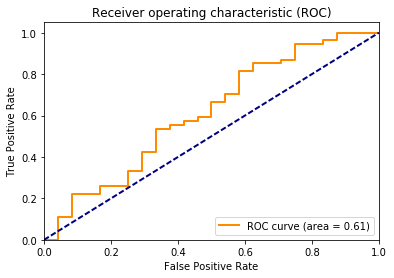

0.5641025641025641

In [71]:
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(
    X_whole, y_whole, test_size=0.3, random_state=0)

def plotGTBClass(X_train, y_train, X_test, y_test):
    """
    Gradient Tree Boosting binary Classification
    """
    clf = GradientBoostingClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
#    y_predict = clf.predict(X_test)
#    print 'y_predict = ', y_predict
    
    y_score = clf.decision_function(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()    
    
    
    
        
#    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
#    print'(tn, fp, fn, tp) : (', tn, fp, fn,tp , ')'
    
#    target_names = ['Down', 'Up']
#    print(classification_report(y_test, y_predict, target_names=target_names))
    
    accuracy = clf.score(X_test, y_test)
    
    return accuracy
plotGTBClass(X_train, y_train, X_test, y_test)

In [16]:
def performQDAClass(X_train, y_train, X_test, y_test):
    """
    Quadratic Discriminant Analysis binary Classification
    """
    print 'QDA classifier: ' 
    
    clf = QDA()
    clf.fit(X_train, y_train)
    
    accuracy = clf.score(X_test, y_test)
    y_predict = clf.predict(X_test)
    print 'y_predict = ', y_predict
        
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print '(tn, fp, fn, tp) : (', tn, fp, fn,tp , ')'
    
    target_names = ['Down', 'Up']
    print(classification_report(y_test, y_predict, target_names=target_names))
    
    return accuracy

#performQDAClass(X_train, y_train, X_test, y_test)

In [23]:
def timeSeriesCV(dataset_X,dataset_y, n_splits, algorithm):
    print dataset_X.shape
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    counter = 0
    accuracies = np.zeros(n_splits)
    print accuracies
    for train_index, test_index in tscv.split(dataset_X):
        counter += 1
        print 'cyle: ', counter
        print 'TRAIN size: ', train_index[-1], 'TEST size: ', test_index[-1] - test_index[0] 
    
        X_train, X_test = dataset_X[:train_index[-1]], dataset_X[test_index[0]:test_index[-1]]
        y_train, y_test = dataset_y[:train_index[-1]], dataset_y[test_index[0]:test_index[-1]]
        
        print 'X_train shape: ', X_train.shape
        print 'X_test shape: ', X_test.shape
        
        index = counter - 1
        accuracies[index] = performClassification(X_train, y_train, X_test, y_test, algorithm)
        print 'Accuracy: ', accuracies[index], '\n'
        
    print 'Average accuracy: ', np.mean(accuracies)
    return np.mean(accuracies)

    
timeSeriesCV(X_whole, y_whole, 10, 'RF')

(260, 27)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cyle:  1
TRAIN size:  29 TEST size:  22
X_train shape:  (29, 27)
X_test shape:  (22, 27)
[ 0.06126556  0.0311603   0.03123462  0.05238686  0.02497402  0.02469113
  0.06501261  0.02659918  0.02734387  0.02413561  0.03737438  0.03777596
  0.05379711  0.02275972  0.02184443  0.03227143  0.02071606  0.02059115
  0.05421943  0.03639035  0.03593895  0.05641469  0.04726261  0.04934597
  0.03001402  0.03703138  0.03744858]
('y_predict = ', array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int64))
(2, 8, 6, 6)
             precision    recall  f1-score   support

       Down       0.25      0.20      0.22        10
         Up       0.43      0.50      0.46        12

avg / total       0.35      0.36      0.35        22

Accuracy:  0.363636363636 

cyle:  2
TRAIN size:  52 TEST size:  22
X_train shape:  (52, 27)
X_test shape:  (22, 27)
[ 0.03713264  0.0314523   0.03118066  0.03107023  0.02433424  0.0255738
  0.031

0.50454545454545452

In [18]:
timeSeriesCV(X_whole, y_whole, 10, 'SVM')

(260, 27)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cyle:  1
TRAIN size:  29 TEST size:  22
X_train shape:  (29, 27)
X_test shape:  (22, 27)
y_predict =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(tn, fp, fn, tp) : ( 0 10 0 12 )
             precision    recall  f1-score   support

       Down       0.00      0.00      0.00        10
         Up       0.55      1.00      0.71        12

avg / total       0.30      0.55      0.39        22

Accuracy:  0.545454545455 

cyle:  2
TRAIN size:  52 TEST size:  22
X_train shape:  (52, 27)
X_test shape:  (22, 27)
y_predict =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(tn, fp, fn, tp) : ( 0 8 0 14 )
             precision    recall  f1-score   support

       Down       0.00      0.00      0.00         8
         Up       0.64      1.00      0.78        14

avg / total       0.40      0.64      0.49        22

Accuracy:  0.636363636364 

cyle:  3
TRAIN size:  75 TEST size:  22
X_train shape:  (75, 27)
X_test shape:  (22, 27)
y_predict = 

C:\Users\ljia\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


y_predict =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(tn, fp, fn, tp) : ( 0 8 0 14 )
             precision    recall  f1-score   support

       Down       0.00      0.00      0.00         8
         Up       0.64      1.00      0.78        14

avg / total       0.40      0.64      0.49        22

Accuracy:  0.636363636364 

cyle:  9
TRAIN size:  213 TEST size:  22
X_train shape:  (213, 27)
X_test shape:  (22, 27)
y_predict =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(tn, fp, fn, tp) : ( 0 10 0 12 )
             precision    recall  f1-score   support

       Down       0.00      0.00      0.00        10
         Up       0.55      1.00      0.71        12

avg / total       0.30      0.55      0.39        22

Accuracy:  0.545454545455 

cyle:  10
TRAIN size:  236 TEST size:  22
X_train shape:  (236, 27)
X_test shape:  (22, 27)
y_predict =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(tn, fp, fn, tp) : ( 0 9 0 13 )
             precision    recall  f1-score   support

   

0.55454545454545445

In [19]:
timeSeriesCV(X_whole, y_whole, 10, 'ADA')

(260, 27)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cyle:  1
TRAIN size:  29 TEST size:  22
X_train shape:  (29, 27)
X_test shape:  (22, 27)
y_predict =  [1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1]
(tn, fp, fn, tp) : ( 2 8 5 7 )
             precision    recall  f1-score   support

       Down       0.29      0.20      0.24        10
         Up       0.47      0.58      0.52        12

avg / total       0.38      0.41      0.39        22

Accuracy:  0.409090909091 

cyle:  2
TRAIN size:  52 TEST size:  22
X_train shape:  (52, 27)
X_test shape:  (22, 27)
y_predict =  [0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0]
(tn, fp, fn, tp) : ( 3 5 7 7 )
             precision    recall  f1-score   support

       Down       0.30      0.38      0.33         8
         Up       0.58      0.50      0.54        14

avg / total       0.48      0.45      0.46        22

Accuracy:  0.454545454545 

cyle:  3
TRAIN size:  75 TEST size:  22
X_train shape:  (75, 27)
X_test shape:  (22, 27)
y_predict =  [0

0.49545454545454548

In [73]:
timeSeriesCV(X_whole, y_whole, 10, 'GTB')

(260, 27)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cyle:  1
TRAIN size:  29 TEST size:  22
X_train shape:  (29, 27)
X_test shape:  (22, 27)
GTB classifier: 
y_predict =  [1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1]
(tn, fp, fn, tp) : ( 3 7 4 8 )
             precision    recall  f1-score   support

       Down       0.43      0.30      0.35        10
         Up       0.53      0.67      0.59        12

avg / total       0.49      0.50      0.48        22

Accuracy:  0.5 

cyle:  2
TRAIN size:  52 TEST size:  22
X_train shape:  (52, 27)
X_test shape:  (22, 27)
GTB classifier: 
y_predict =  [0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0]
(tn, fp, fn, tp) : ( 3 5 6 8 )
             precision    recall  f1-score   support

       Down       0.33      0.38      0.35         8
         Up       0.62      0.57      0.59        14

avg / total       0.51      0.50      0.51        22

Accuracy:  0.5 

cyle:  3
TRAIN size:  75 TEST size:  22
X_train shape:  (75, 27)
X_test shape:  (22, 27)
GTB

0.57272727272727275

In [21]:
timeSeriesCV(X_whole, y_whole, 10, 'QDA')

(260, 27)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cyle:  1
TRAIN size:  29 TEST size:  22
X_train shape:  (29, 27)
X_test shape:  (22, 27)
y_predict =  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
(tn, fp, fn, tp) : ( 9 1 10 2 )
             precision    recall  f1-score   support

       Down       0.47      0.90      0.62        10
         Up       0.67      0.17      0.27        12

avg / total       0.58      0.50      0.43        22

Accuracy:  0.5 

cyle:  2
TRAIN size:  52 TEST size:  22
X_train shape:  (52, 27)
X_test shape:  (22, 27)
y_predict =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(tn, fp, fn, tp) : ( 0 8 0 14 )
             precision    recall  f1-score   support

       Down       0.00      0.00      0.00         8
         Up       0.64      1.00      0.78        14

avg / total       0.40      0.64      0.49        22

Accuracy:  0.636363636364 

cyle:  3
TRAIN size:  75 TEST size:  22
X_train shape:  (75, 27)
X_test shape:  (22, 27)
y_predict =  [1 1 1 1 1 

C:\Users\ljia\Anaconda3\envs\py27\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


 4 )
             precision    recall  f1-score   support

       Down       0.33      0.25      0.29        12
         Up       0.31      0.40      0.35        10

avg / total       0.32      0.32      0.31        22

Accuracy:  0.318181818182 

cyle:  6
TRAIN size:  144 TEST size:  22
X_train shape:  (144, 27)
X_test shape:  (22, 27)
y_predict =  [0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1]
(tn, fp, fn, tp) : ( 3 5 4 10 )
             precision    recall  f1-score   support

       Down       0.43      0.38      0.40         8
         Up       0.67      0.71      0.69        14

avg / total       0.58      0.59      0.58        22

Accuracy:  0.590909090909 

cyle:  7
TRAIN size:  167 TEST size:  22
X_train shape:  (167, 27)
X_test shape:  (22, 27)
y_predict =  [1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1]
(tn, fp, fn, tp) : ( 3 8 3 8 )
             precision    recall  f1-score   support

       Down       0.50      0.27      0.35        11
         Up       0.50      0.73      0

0.50454545454545452

In [22]:
timeSeriesCV(X_whole, y_whole, 10, 'KNN')

(260, 27)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
cyle:  1
TRAIN size:  29 TEST size:  22
X_train shape:  (29, 27)
X_test shape:  (22, 27)
y_predict =  [0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0]
(tn, fp, fn, tp) : ( 5 5 7 5 )
             precision    recall  f1-score   support

       Down       0.42      0.50      0.45        10
         Up       0.50      0.42      0.45        12

avg / total       0.46      0.45      0.45        22

Accuracy:  0.454545454545 

cyle:  2
TRAIN size:  52 TEST size:  22
X_train shape:  (52, 27)
X_test shape:  (22, 27)
y_predict =  [0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0]
(tn, fp, fn, tp) : ( 3 5 6 8 )
             precision    recall  f1-score   support

       Down       0.33      0.38      0.35         8
         Up       0.62      0.57      0.59        14

avg / total       0.51      0.50      0.51        22

Accuracy:  0.5 

cyle:  3
TRAIN size:  75 TEST size:  22
X_train shape:  (75, 27)
X_test shape:  (22, 27)
y_predict =  [0 1 1 1 0 1 

0.53181818181818186